In [1]:
import re
from decimal import Decimal
from typing import List, Tuple
import numpy as np
from io import StringIO

def parse_si(si_num: str) -> float:
    """Parses an SI number of the form 4n or 20u or 4meg"""
    normed = si_num.lower()
    val = float(re.sub(r'[a-zµ]+', '', normed))
    post = re.sub(r'[\d.]+', '', normed)
    if post == 'meg':
        return val * 1e6
    if post == 'k':
        return val * 1e3
    if post == '':
        return val
    if post == 'm':
        return val * 1e-3
    if post in {'u', 'µ'}:
        return val * 1e-6
    if post == 'n':
        return val * 1e-9
    raise ValueError('Invalid postfix `{}`'.format(post))

def parse_section_head(section: str) -> List[Tuple[str, float]]:
    fields = section[0:section.find('(')-2].split(' ')
    return [(field.split('=')[0], parse_si(field.split('=')[1])) for field in fields]

def parse_section(section: str) -> Tuple[List[Tuple[str, float]], Tuple[List[float], List[float]]]:
    data = np.genfromtxt(StringIO(section), skip_header=1)
    parameters = parse_section_head(section)
    return parameters, data

In [2]:
import multiprocessing
pool = multiprocessing.Pool()

In [17]:
datafile = open('filter buck converter.txt', encoding='cp1252')
sections = datafile.read().split('Step Information: ')[1:]

parsed_sections = pool.map(parse_section, sections)
print(parsed_sections[0])

([('C_out', 1.0000000000000001e-07), ('I_out', 1.0000000000000001e-07)], array([[0.00000000e+00, 0.00000000e+00],
       [1.23333339e-12, 2.95702200e-11],
       [1.50000012e-12, 3.86859200e-11],
       ...,
       [4.79996058e-03, 1.07211100e-01],
       [4.79998058e-03, 1.07147100e-01],
       [4.80000000e-03, 1.07085700e-01]]))


In [18]:
def get_pk_pk(section) -> Tuple[float, float, float]:
    s1d = section[1]
    recent_vals = s1d[s1d[:,0] > parse_si('3m')]
    return (section[0][0][1], section[0][1][1], max(recent_vals[:,1])-min(recent_vals[:,1]))

heat = list(map(get_pk_pk, parsed_sections))
sorted(heat, key=lambda tup: tup[2])

[(2.2e-05, 9.999999999999999e-06, 0.08484999999999943),
 (9.999999999999999e-06, 9.999999999999999e-06, 0.18640999999999863),
 (2.2e-05, 3.1622799999999996e-06, 0.26998999999999995),
 (3.1622799999999996e-06, 9.999999999999999e-06, 0.5735699999999984),
 (9.999999999999999e-06, 3.1622799999999996e-06, 0.5978499999999993),
 (2.2e-05, 1e-06, 0.8710400000000007),
 (1e-06, 9.999999999999999e-06, 1.4266900000000007),
 (3.1622799999999996e-06, 3.1622799999999996e-06, 1.8925900000000002),
 (9.999999999999999e-06, 1e-06, 1.9792700000000014),
 (3.16228e-07, 9.999999999999999e-06, 2.0695000000000014),
 (1.0000000000000001e-07, 9.999999999999999e-06, 2.294780000000001),
 (2.2e-05, 3.16228e-07, 2.9485599999999987),
 (1e-06, 3.1622799999999996e-06, 4.854493),
 (3.16228e-07, 3.1622799999999996e-06, 6.762988),
 (3.1622799999999996e-06, 1e-06, 6.905932),
 (1.0000000000000001e-07, 3.1622799999999996e-06, 7.214667),
 (9.999999999999999e-06, 3.16228e-07, 7.325329),
 (2.2e-05, 1.0000000000000001e-07, 11.82

<IPython.core.display.Javascript object>


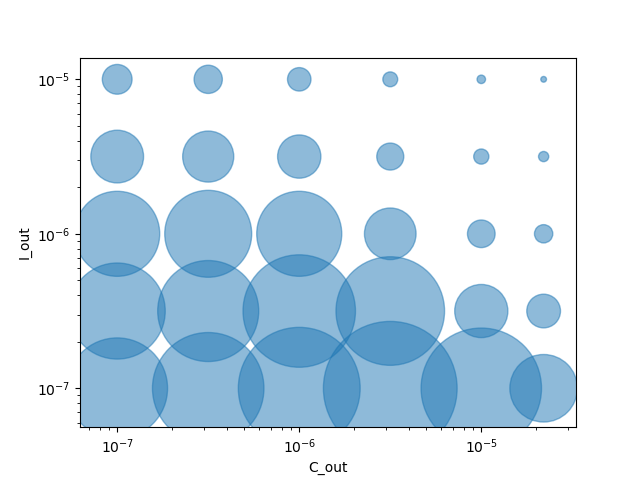

In [19]:
import matplotlib.pyplot as plt
import scipy.fftpack
%matplotlib notebook 

(X, Y, V) = np.transpose(np.array(heat))

plt.yscale('log')
plt.xscale('log')
plt.xlabel(parsed_sections[9][0][0][0])
plt.ylabel(parsed_sections[0][0][1][0])
plt.scatter(X, Y, s=V*200, alpha=0.5)
plt.show()